In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import networkx as nx
import networkx as nx
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sns.set_theme()

# 1. Pre-processing

In [2]:
df_ba_beers     = pd.read_csv('src/data/beer_advocate/beers.csv')
# df_ba_breweries = pd.read_csv('src/data/beer_advocate/breweries.csv')
df_ba_users     = pd.read_csv('src/data/beer_advocate/users.csv')
df_ba_ratings   = pd.read_csv('src/data/beer_advocate/ratings.csv')
df_ba_user_beer_style_past_ratings = pd.read_csv("src/data/beer_advocate/user_beer_style_past_ratings.csv")

In [3]:
df_rb_beers     = pd.read_csv('src/data/rate_beer/beers.csv')
# df_rb_breweries = pd.read_csv('src/data/rate_beer/breweries.csv')
df_rb_users     = pd.read_csv('src/data/rate_beer/users.csv')
df_rb_ratings   = pd.read_csv('src/data/rate_beer/ratings.csv')
df_rb_user_beer_style_past_ratings = pd.read_csv("src/data/rate_beer/user_beer_style_past_ratings.csv")

In [4]:
df_rb_user_beer_style_past_ratings.head()

,user_past_ratings_Bock_count,user_past_ratings_Brown Ale_count,user_past_ratings_Dark Ales_count,user_past_ratings_Dark Lager_count,user_past_ratings_Hybrid Beer_count,user_past_ratings_India Pale Ale_count,user_past_ratings_Pale Ale_count,user_past_ratings_Pale Lager_count,user_past_ratings_Porter_count,user_past_ratings_Speciality Beer_count,...,user_past_ratings_Pale Lager_average,user_past_ratings_Porter_average,user_past_ratings_Speciality Beer_average,user_past_ratings_Stout_average,user_past_ratings_Strong Ale_average,user_past_ratings_Wheat Beer_average,user_past_ratings_Wild/Sour Beer_average,user_id,date,beer_id
0,0.0,2.0,0.0,0.0,0.0,5.0,11.0,0.0,1.0,0.0,...,0.00,4.9,0.0,3.55,0.0,0.0,0.0,2,959076000,37
1,0.0,2.0,0.0,1.0,0.0,5.0,12.0,2.0,1.0,0.0,...,2.35,4.9,0.0,3.55,0.0,0.0,0.0,2,959508000,47
2,0.0,2.0,0.0,1.0,1.0,5.0,15.0,3.0,1.0,0.0,...,2.70,4.9,0.0,3.55,0.0,4.1,0.0,2,961927200,48
3,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,...,0.00,4.9,0.0,2.40,0.0,0.0,0.0,2,957348000,86
4,0.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,...,0.00,4.9,0.0,2.40,0.0,0.0,0.0,2,957348000,89


In [5]:
df_ba_ratings = df_ba_ratings.loc[~(df_ba_ratings['beer_global_style'] == 'Low Alcohol Beer')]
df_rb_ratings = df_rb_ratings.loc[~(df_rb_ratings['beer_global_style'] == 'Low Alcohol Beer')]

In [6]:
df_ba_user_beer_style_past_ratings = df_ba_user_beer_style_past_ratings.drop(columns=['user_past_ratings_Low Alcohol Beer_count', 'user_past_ratings_Low Alcohol Beer_average'], errors='ignore')
df_rb_user_beer_style_past_ratings = df_rb_user_beer_style_past_ratings.drop(columns=['user_past_ratings_Low Alcohol Beer_count', 'user_past_ratings_Low Alcohol Beer_average'], errors='ignore')

In [7]:
df_ba_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_ba_ratings["user_beer_style_past_ratings_count"] - 1
df_ba_ratings.loc[df_ba_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan

df_rb_ratings.loc[:,"user_beer_style_past_ratings_count"] = df_rb_ratings["user_beer_style_past_ratings_count"] - 1
df_rb_ratings.loc[df_rb_ratings["user_beer_style_past_ratings_count"] == 0,"user_beer_style_past_ratings_average"] = np.nan

In [8]:
def create_time_variables(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe['day']     = pd.to_datetime(dataframe['date'], unit='s').dt.round('D')
    dataframe['week']    = pd.to_datetime(dataframe['date'], unit='s').dt.to_period('W').dt.start_time
    dataframe['month']   = pd.to_datetime(dataframe['date'], unit='s').dt.to_period('M').dt.start_time
    dataframe['quarter'] = pd.to_datetime(dataframe['date'], unit='s').dt.to_period('Q')
    dataframe['year']    = pd.to_datetime(dataframe['date'], unit='s').dt.to_period('Y')
    return dataframe 

In [9]:
df_ba_ratings = create_time_variables(df_ba_ratings)
df_rb_ratings = create_time_variables(df_rb_ratings)

# 2. Data selection

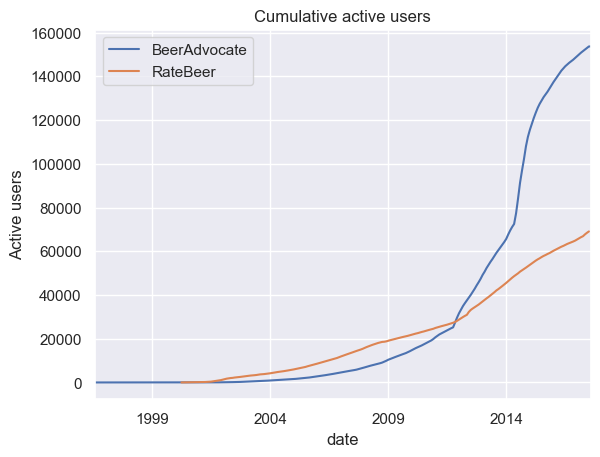

In [10]:
plt.title('Cumulative active users')
plt.xlabel('Month')
plt.ylabel('Active users')
pd.to_datetime(df_ba_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='BeerAdvocate')
pd.to_datetime(df_rb_ratings.sort_values(['date']).groupby('user_id')['date'].first(), unit='s').dt.to_period('M').value_counts().sort_index().cumsum().plot(label='RateBeer')
plt.legend()

In [11]:
def compute_cumulative_ratings_count(dataframe: pd.DataFrame):
    dataframe = dataframe.sort_values(['date'])
    dataframe['_count'] = 1
    dataframe['cumulative_ratings_count'] = dataframe['_count'].cumsum()
    dataframe = dataframe.drop(columns=['_count'])
    return dataframe

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

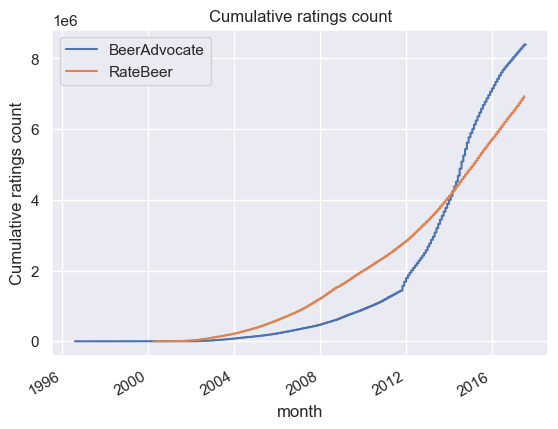

In [12]:
fig, ax = plt.subplots()
plt.title('Cumulative ratings count')
plt.xlabel('Month')
plt.ylabel('Cumulative ratings count')
compute_cumulative_ratings_count(df_ba_ratings).plot(x='month', y='cumulative_ratings_count', label='BeerAdvocate', ax=ax)
compute_cumulative_ratings_count(df_rb_ratings).plot(x='month', y='cumulative_ratings_count', label='RateBeer', ax=ax)

In [13]:
def remove_before_month(dataframe: pd.DataFrame, month: str) -> pd.DataFrame:
    dataframe = dataframe.sort_values(['user_id', 'date'])
    dataframe = dataframe.merge(
        (dataframe.groupby('user_id')['month'].first() >= month).reset_index().rename(columns={'month': 'is_first_rating_after_month'}),
        on='user_id'
    )
    dataframe = dataframe[dataframe['is_first_rating_after_month']]
    dataframe = dataframe.drop(columns=['is_first_rating_after_month'])
    return dataframe

In [14]:
df_ba_ratings = remove_before_month(df_ba_ratings, '2004-01')
df_rb_ratings = remove_before_month(df_rb_ratings, '2004-01')

# 3. Beer Advocate vs Rate Beer

# 4. Expert

In [15]:
from src.utils.beer_knowledge import (
    number_of_beer_per_style,
    add_global_knowledge, 
    add_local_knowledge, 
    add_experts, 
    get_expert_per_day, 
    get_global_expert_per_day
)

In [24]:
df_ba_current_beer_per_style = number_of_beer_per_style(df_ba_ratings)
df_rb_current_beer_per_style = number_of_beer_per_style(df_rb_ratings)

df_ba_current_beer_per_style.drop(df_ba_current_beer_per_style[df_ba_current_beer_per_style["day"] < "2004-01-01"].index, axis=0, inplace=True)
df_rb_current_beer_per_style.drop(df_rb_current_beer_per_style[df_rb_current_beer_per_style["day"] < "2004-01-01"].index, axis=0, inplace=True)

In [25]:
df_ba_user_beer_style_past_ratings = df_ba_user_beer_style_past_ratings[df_ba_user_beer_style_past_ratings["user_id"].isin(df_ba_ratings["user_id"].drop_duplicates())]
df_rb_user_beer_style_past_ratings = df_rb_user_beer_style_past_ratings[df_rb_user_beer_style_past_ratings["user_id"].isin(df_rb_ratings["user_id"].drop_duplicates())]

In [32]:
df_ba_user_beer_style_past_ratings['day'] = pd.to_datetime(df_ba_user_beer_style_past_ratings['date'], unit="s").dt.round('D')
df_rb_user_beer_style_past_ratings['day'] = pd.to_datetime(df_rb_user_beer_style_past_ratings['date'], unit="s").dt.round('D')

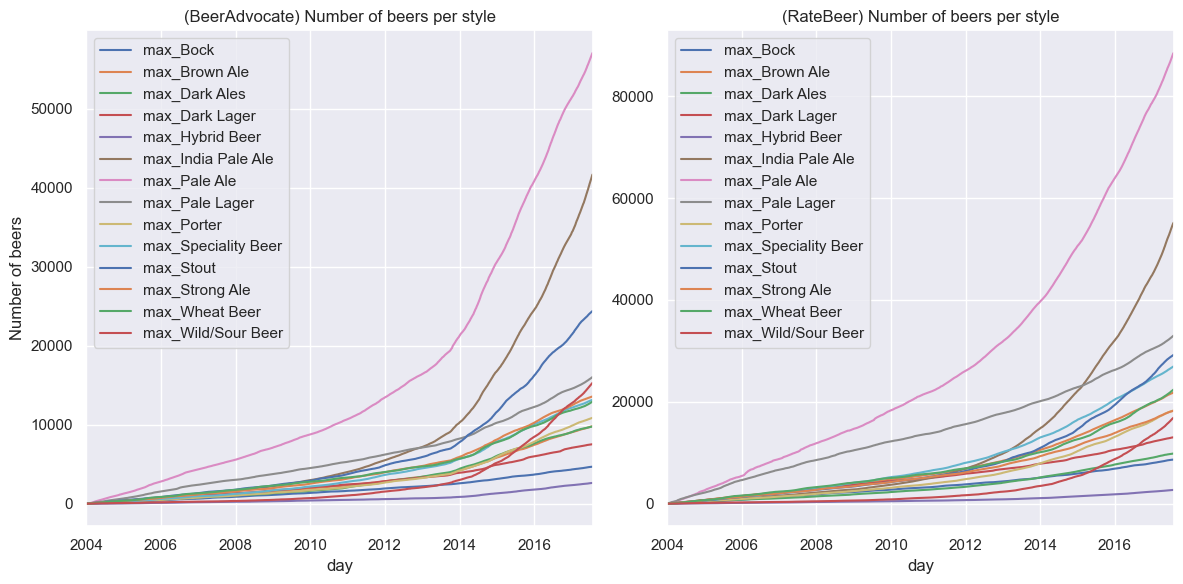

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title('(BeerAdvocate) Number of beers per style')
axs[1].set_title('(RateBeer) Number of beers per style')
axs[0].set_xlabel('Day')
axs[1].set_xlabel('Day')
axs[0].set_ylabel('Number of beers')

df_ba_current_beer_per_style.plot(x='day', ax=axs[0])
df_rb_current_beer_per_style.plot(x='day', ax=axs[1])

plt.tight_layout()
plt.show()

In [31]:
df_ba_user_beer_style_past_ratings.head()

,user_past_ratings_Bock_count,user_past_ratings_Brown Ale_count,user_past_ratings_Dark Ales_count,user_past_ratings_Dark Lager_count,user_past_ratings_Hybrid Beer_count,user_past_ratings_India Pale Ale_count,user_past_ratings_Pale Ale_count,user_past_ratings_Pale Lager_count,user_past_ratings_Porter_count,user_past_ratings_Speciality Beer_count,...,user_past_ratings_Stout_average,user_past_ratings_Strong Ale_average,user_past_ratings_Wheat Beer_average,user_past_ratings_Wild/Sour Beer_average,user_id,date,beer_id,style_tried,style_tried_share,mean_beer_tried
0,108.0,206.0,322.0,168.0,43.0,1003.0,1243.0,323.0,295.0,297.0,...,3.913716,3.862249,3.568638,3.88506,nmann08.184925,1440064800,142544,14.0,1.000000,422.357143
1,1.0,0.0,2.0,2.0,0.0,8.0,3.0,0.0,3.0,1.0,...,3.896667,0.000000,3.800000,0.00000,stjamesgate.163714,1235127600,19590,9.0,0.642857,3.000000
2,3.0,3.0,17.0,5.0,0.0,4.0,29.0,8.0,8.0,11.0,...,4.155000,4.197333,4.089000,3.98625,mdagnew.19527,1142247600,19590,13.0,0.928571,10.230769
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,helloloser12345.10867,1101898800,19590,1.0,0.071429,1.000000
4,0.0,6.0,6.0,6.0,1.0,5.0,43.0,62.0,2.0,4.0,...,3.771818,3.801111,3.623000,4.52000,cypressbob.3708,1093860000,19590,13.0,0.928571,12.769231


In [33]:
ba_average_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "average" in col]
ba_count_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "count" in col]
ba_max_columns = [col for col in df_ba_current_beer_per_style.columns if "max" in col]

df_ba_user_beer_style_past_ratings = add_global_knowledge(df_ba_current_beer_per_style, df_ba_user_beer_style_past_ratings, ba_count_columns)
df_ba_user_beer_style_past_ratings, df_ba_local_knowledge = add_local_knowledge(df_ba_current_beer_per_style, df_ba_user_beer_style_past_ratings, ba_max_columns, ba_count_columns)

df_ba_knowledge = df_ba_user_beer_style_past_ratings[["user_id","day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_ba_knowledge.loc[:,"knowledge"] = (df_ba_knowledge["global_knowledge"] + df_ba_knowledge["local_knowledge"]) / 2

df_ba_knowledge = df_ba_knowledge.drop(df_ba_knowledge[df_ba_knowledge["local_knowledge"] == 0].index, axis=0)

df_ba_prime_knowledge = df_ba_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

/Users/jnsffrt/epfl/ma1/cs401/PDfromSCRATCH_project/src/utils/beer_knowledge.py:105: RuntimeWarning: invalid value encountered in divide
  df_users_past_beer_style[count_columns].values


AttributeError: module 'numpy' has no attribute 'pow'

In [ ]:
rb_average_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "average" in col]
rb_count_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "count" in col]
rb_max_columns = [col for col in df_rb_current_beer_per_style.columns if "max" in col]

df_rb_user_beer_style_past_ratings = add_global_knowledge(df_rb_current_beer_per_style, df_rb_user_beer_style_past_ratings, rb_count_columns)
df_rb_user_beer_style_past_ratings, df_rb_local_knowledge = add_local_knowledge(df_rb_current_beer_per_style, df_rb_user_beer_style_past_ratings, rb_max_columns, rb_count_columns)

df_rb_knowledge = df_rb_user_beer_style_past_ratings[["user_id","date_day","beer_id","global_knowledge","local_knowledge","style_tried"]]
df_rb_knowledge.loc[:,"knowledge"] = (df_rb_knowledge["global_knowledge"] + df_rb_knowledge["local_knowledge"]) / 2

df_rb_knowledge = df_rb_knowledge.drop(df_rb_knowledge[df_rb_knowledge["local_knowledge"] == 0].index, axis=0)

df_rb_prime_knowledge = df_rb_knowledge[["user_id","global_knowledge","local_knowledge","knowledge"]].groupby("user_id").max().reset_index()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
axs = axs.ravel()

axs[0].set_title('(Beer Advocate) Distribution of Knowledge')
axs[0].set_xlabel('Knowledge')
axs[0].set_xlim([0,1])

axs[1].set_title('(Beer Advocate) Distribution of Global Knowledge')
axs[1].set_xlabel('Global Knowledge')
axs[1].set_xlim([0,1])

axs[2].set_title('(Beer Advocate) Distribution of Local Knowledge')
axs[2].set_xlabel('Local Knowledge')
axs[2].set_xlim([0,1])

axs[3].set_title('(Rate Beer) Distribution of Knowledge')
axs[3].set_xlabel('Knowledge')
axs[3].set_xlim([0,1])

axs[4].set_title('(Rate Beer) Distribution of Global Knowledge')
axs[4].set_xlabel('Global Knowledge')
axs[4].set_xlim([0,1])

axs[5].set_title('(Rate Beer) Distribution of Local Knowledge')
axs[5].set_xlabel('Local Knowledge')
axs[5].set_xlim([0,1])

df_ba_prime_knowledge["knowledge"].hist(bins=100, ax=axs[0])
df_ba_prime_knowledge["global_knowledge"].hist(bins=100, ax=axs[1])
df_ba_prime_knowledge["local_knowledge"].hist(bins=100, ax=axs[2])

df_rb_prime_knowledge["knowledge"].hist(bins=100, ax=axs[3], color='orange')
df_rb_prime_knowledge["global_knowledge"].hist(bins=100, ax=axs[4], color='orange')
df_rb_prime_knowledge["local_knowledge"].hist(bins=100, ax=axs[5], color='orange')

plt.tight_layout()
plt.show()

In [ ]:
# Save memory
del df_ba_prime_knowledge
del df_rb_prime_knowledge

In [ ]:
df_ba_highest_global_knowledge = df_ba_knowledge.loc[df_ba_knowledge[["user_id","global_knowledge"]].groupby("user_id").idxmax().reset_index()["global_knowledge"]]
df_rb_highest_global_knowledge = df_rb_knowledge.loc[df_rb_knowledge[["user_id","global_knowledge"]].groupby("user_id").idxmax().reset_index()["global_knowledge"]]

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('(BeerAdvocate) Distribution of Global Knowledge by style tried')
plt.xlabel('Style tried')
plt.ylabel('Global Knowledge')
sns.violinplot(x=df_ba_highest_global_knowledge["style_tried"],y=df_ba_highest_global_knowledge["global_knowledge"],hue=df_ba_highest_global_knowledge["style_tried"])
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('(RateBeer) Distribution of Global Knowledge by style tried')
plt.xlabel('Style tried')
plt.ylabel('Global Knowledge')
sns.violinplot(x=df_rb_highest_global_knowledge["style_tried"],y=df_rb_highest_global_knowledge["global_knowledge"],hue=df_rb_highest_global_knowledge["style_tried"])
plt.show()

In [ ]:
# Save memory
del df_ba_highest_global_knowledge
del df_rb_highest_global_knowledge

### Local knowledge

In [ ]:
df_ba_prime_local_knowledge = df_ba_local_knowledge.iloc[:,:-2].groupby("user_id").max().reset_index()
df_rb_prime_local_knowledge = df_rb_local_knowledge.iloc[:,:-2].groupby("user_id").max().reset_index()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('(BeerAdvocate) Distribution of Local Knowledge')
plt.xlabel('Local Knowledge')
plt.ylabel('Density')
sns.violinplot(df_ba_prime_local_knowledge.iloc[:,1:].fillna(0))
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('(RateBeer) Distribution of Local Knowledge')
plt.xlabel('Local Knowledge')
plt.ylabel('Density')
sns.violinplot(df_ba_prime_local_knowledge.iloc[:,1:].fillna(0))
plt.show()

In [ ]:
# Save memory
del df_ba_prime_local_knowledge
del df_rb_prime_local_knowledge

### Experts

In [ ]:
df_ba_user_beer_style_past_ratings, df_ba_local_knowledge_quantile_expert = add_experts(df_ba_local_knowledge, df_ba_user_beer_style_past_ratings, 0.99)
df_rb_user_beer_style_past_ratings, df_rb_local_knowledge_quantile_expert = add_experts(df_rb_local_knowledge, df_rb_user_beer_style_past_ratings, 0.99)

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Required Local Knowledge to be an expert in a Beer Style")
plt.xlabel("Beer Style")
plt.ylabel("Local Knowledge to be an expert")
sns.barplot(x=df_ba_local_knowledge_quantile_expert.index, y=df_ba_local_knowledge_quantile_expert.sort_values(), hue=df_ba_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Required Local Knowledge to be an expert in a Beer Style")
plt.xlabel("Beer Style")
plt.ylabel("Local Knowledge to be an expert")
sns.barplot(x=df_rb_local_knowledge_quantile_expert.index, y=df_rb_local_knowledge_quantile_expert.sort_values(), hue=df_rb_local_knowledge_quantile_expert.index)
plt.xticks(rotation=45)
plt.show()

In [ ]:
ba_max_available_beer_per_day = df_ba_user_beer_style_past_ratings[ba_max_columns+["day"]].groupby("day").max().reset_index()
ba_max_available_beer_per_day.columns = ["day"] + df_ba_local_knowledge_quantile_expert.index.to_list()
ba_max_available_beer_per_day.iloc[:,1:] = ba_max_available_beer_per_day.iloc[:,1:] * np.pow(df_ba_local_knowledge_quantile_expert,3)
df_ba_beer_required_to_be_expert_long = ba_max_available_beer_per_day.melt(id_vars='day', var_name='Beer Style', value_name='Beers to be expert')

In [ ]:
rb_max_available_beer_per_day = df_rb_user_beer_style_past_ratings[rb_max_columns+["day"]].groupby("day").max().reset_index()
rb_max_available_beer_per_day.columns = ["day"] + df_rb_local_knowledge_quantile_expert.index.to_list()
rb_max_available_beer_per_day.iloc[:,1:] = rb_max_available_beer_per_day.iloc[:,1:] * np.pow(df_rb_local_knowledge_quantile_expert,3)
df_rb_beer_required_to_be_expert_long = rb_max_available_beer_per_day.melt(id_vars='day', var_name='Beer Style', value_name='Beers to be expert')

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Required Beers to be an expert in a style")
plt.xlabel("Day")
plt.ylabel("Beers to be expert")
sns.lineplot(x=df_ba_beer_required_to_be_expert_long["day"], y=df_ba_beer_required_to_be_expert_long["Beers to be expert"], hue=df_ba_beer_required_to_be_expert_long["Beer Style"])
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Required Beers to be an expert in a style")
plt.xlabel("Day")
plt.ylabel("Beers to be expert")
sns.lineplot(x=df_ba_beer_required_to_be_expert_long["day"], y=df_ba_beer_required_to_be_expert_long["Beers to be expert"], hue=df_ba_beer_required_to_be_expert_long["Beer Style"])
plt.show()

In [ ]:
ba_expert_columns = [col for col in df_ba_user_beer_style_past_ratings.columns if "expert" in col]
ba_n_unique_experts_per_style = df_ba_user_beer_style_past_ratings[ba_expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_ba_user_beer_style_past_ratings.loc[:,"isExpert"] = df_ba_user_beer_style_past_ratings[ba_expert_columns].sum(axis=1)
df_ba_expert_users = df_ba_user_beer_style_past_ratings.loc[df_ba_user_beer_style_past_ratings["isExpert"] >= 1,["user_id"] + ba_expert_columns].groupby("user_id").max().reset_index().merge(df_ba_users[["user_id","user_country"]], how="left", on="user_id")

df_ba_expert_users = df_ba_expert_users.merge(df_ba_users[["user_id","user_country_code"]], how="left", on="user_id")

df_ba_count_exp = df_ba_expert_users["user_country_code"].value_counts().reset_index()
df_ba_count_exp["log_count"] = np.log(df_ba_count_exp["count"])

In [ ]:
rb_expert_columns = [col for col in df_rb_user_beer_style_past_ratings.columns if "expert" in col]
rb_n_unique_experts_per_style = df_rb_user_beer_style_past_ratings[rb_expert_columns+["user_id"]].groupby("user_id").max().reset_index().iloc[:,1:].sum()

df_rb_user_beer_style_past_ratings.loc[:,"isExpert"] = df_rb_user_beer_style_past_ratings[rb_expert_columns].sum(axis=1)
df_rb_expert_users = df_rb_user_beer_style_past_ratings.loc[df_rb_user_beer_style_past_ratings["isExpert"] >= 1,["user_id"] + rb_expert_columns].groupby("user_id").max().reset_index().merge(df_rb_users[["user_id","user_country"]], how="left", on="user_id")

df_rb_expert_users = df_rb_expert_users.merge(df_rb_users[["user_id","user_country_code"]], how="left", on="user_id")

df_rb_count_exp = df_rb_expert_users["user_country_code"].value_counts().reset_index()
df_rb_count_exp["log_count"] = np.log(df_rb_count_exp["count"])

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(df_ba_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.title(f"(BeerAdvocate) Number of local expert in any beer style for each country : {df_ba_expert_users["user_country"].value_counts().sum().item()} experts")
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.yscale("log")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(df_ba_expert_users["user_country"].value_counts(), color='orange')
plt.xticks(rotation=90)
plt.title(f"(RateBeer) Number of local expert in any beer style for each country : {df_ba_expert_users["user_country"].value_counts().sum().item()} experts")
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.yscale("log")
plt.show()

In [ ]:
fig = px.choropleth(
    df_ba_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), geo=dict(showframe=False, showcoastlines=True, projection_type='mercator'))
fig.show()

In [ ]:
fig = px.choropleth(
    df_rb_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), geo=dict(showframe=False, showcoastlines=True, projection_type='mercator'))
fig.show()

In [ ]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)

for col_idx, col in enumerate(ba_expert_columns):
    sns.barplot(df_ba_expert_users[df_ba_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7])
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_ba_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2,7,figsize=(30,20),sharey=True)

for col_idx, col in enumerate(rb_expert_columns):
    sns.barplot(df_rb_expert_users[df_rb_expert_users[col] == 1]["user_country"].value_counts(), ax=axes[col_idx//7,col_idx%7], color='orange')
    #axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx//7,col_idx%7].set_xticklabels(axes[col_idx//7,col_idx%7].get_xticklabels(), rotation=90)
    axes[col_idx//7,col_idx%7].set_xlabel("")
    #plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx//7,col_idx%7].set_title(f"{col.split("_")[0]} : {df_rb_expert_users[col].sum()} experts")
    axes[col_idx//7,col_idx%7].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
df_ba_user_beer_style_past_ratings['month']   = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.to_period("M").dt.start_time
df_ba_user_beer_style_past_ratings['quarter'] = pd.to_datetime(df_ba_ratings['date'], unit="s").dt.to_period("Q").dt.start_time

df_rb_user_beer_style_past_ratings['month']   = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.to_period("M").dt.start_time
df_rb_user_beer_style_past_ratings['quarter'] = pd.to_datetime(df_rb_ratings['date'], unit="s").dt.to_period("Q").dt.start_time

In [ ]:
df_ba_expert_per_day = df_ba_user_beer_style_past_ratings[ba_expert_columns+["month", "user_id"]].groupby(["user_id", "month"]).max().reset_index().iloc[:,1:].groupby("month").sum().reset_index()
df_ba_expert_per_day_long = df_ba_expert_per_day.melt(id_vars='month', var_name='Beer Style', value_name='Number of expert ratings')

df_rb_expert_per_day = df_rb_user_beer_style_past_ratings[rb_expert_columns+["month", "user_id"]].groupby(["user_id", "month"]).max().reset_index().iloc[:,1:].groupby("month").sum().reset_index()
df_rb_expert_per_day_long = df_rb_expert_per_day.melt(id_vars='month', var_name='Beer Style', value_name='Number of expert ratings')

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Number of expert ratings per month")
plt.xlabel("Month")
plt.ylabel("Number of expert ratings")
sns.lineplot(data=df_ba_expert_per_day_long,x="date_month",y='Number of expert ratings', hue="Beer Style")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Number of expert ratings per month")
plt.xlabel("Month")
plt.ylabel("Number of expert ratings")
sns.lineplot(data=df_ba_expert_per_day_long,x="date_month",y='Number of expert ratings', hue="Beer Style")
plt.show()

In [ ]:
df_ba_expert_ratings = df_ba_user_beer_style_past_ratings[ba_expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_ba_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
df_ba_to_plots = []
TOP_K_BEERS_THRESH = 100
for style in ba_expert_columns:
    beer_rated_by_experts = df_ba_expert_ratings[(df_ba_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_ba_ratings[(df_ba_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(TOP_K_BEERS_THRESH)["beer_id"].to_numpy()
    df_same_beers = df_ba_expert_ratings[(df_ba_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_ba_expert_ratings["beer_id"].isin(top_k_beers))]
    df_ba_to_plots.append(df_same_beers[["beer_global_style","rating",style]].rename(columns={style:"expert"}))
df_ba_to_barplot = pd.concat(df_ba_to_plots,axis=0)

In [ ]:
df_rb_expert_ratings = df_rb_user_beer_style_past_ratings[rb_expert_columns+["date_day","user_id","beer_id"]].groupby(["user_id","date_day"]).max().reset_index().merge(df_rb_ratings[["user_id","date_day","beer_global_style","rating"]], how="inner", on=["user_id","date_day"])
df_rb_to_plots = []
TOP_K_BEERS_THRESH = 100
for style in rb_expert_columns:
    beer_rated_by_experts = df_rb_expert_ratings[(df_rb_expert_ratings[style] == 1)]["beer_id"].unique()
    top_k_beers = df_rb_ratings[(df_rb_ratings["beer_global_style"] == style.split("_")[0]) & (df_rb_ratings["beer_id"].isin(beer_rated_by_experts))][["rating","beer_id"]].groupby("beer_id").count().reset_index().sort_values(by="rating",ascending=False).head(TOP_K_BEERS_THRESH)["beer_id"].to_numpy()
    df_same_beers = df_rb_expert_ratings[(df_rb_expert_ratings["beer_global_style"] == style.split("_")[0]) & (df_rb_expert_ratings["beer_id"].isin(top_k_beers))]
    df_rb_to_plots.append(df_same_beers[["beer_global_style","rating",style]].rename(columns={style:"expert"}))
df_rb_to_barplot = pd.concat(df_rb_to_plots,axis=0)

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Average rating of expert and non-expert users")
plt.xlabel("Beer Style")
plt.ylabel("Rating")
sns.barplot(data=df_ba_to_barplot,x="beer_global_style", y="rating", hue="expert")
plt.xticks(rotation=45)
plt.ylim([3,4.5])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Average rating of expert and non-expert users")
plt.xlabel("Beer Style")
plt.ylabel("Rating")
sns.barplot(data=df_rb_to_barplot,x="beer_global_style", y="rating", hue="expert")
plt.xticks(rotation=45)
plt.ylim([3,4.5])
plt.tight_layout()
plt.show()

In [ ]:
df_ba_expert_per_day = df_ba_user_beer_style_past_ratings[ba_expert_columns+["date_quarter","user_id"]].groupby(["user_id","date_quarter"]).max().reset_index().iloc[:,1:].groupby("date_quarter").sum().reset_index()
df_ba_expert_per_day_long = df_ba_expert_per_day.melt(id_vars='date_quarter', var_name='Beer Style', value_name='Number of expert ratings')

df_rb_expert_per_day = df_rb_user_beer_style_past_ratings[rb_expert_columns+["date_quarter","user_id"]].groupby(["user_id","date_quarter"]).max().reset_index().iloc[:,1:].groupby("date_quarter").sum().reset_index()
df_rb_expert_per_day_long = df_rb_expert_per_day.melt(id_vars='date_quarter', var_name='Beer Style', value_name='Number of expert ratings')

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Number of expert ratings per quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of expert ratings")
sns.lineplot(data=df_ba_expert_per_day_long,x="date_quarter",y='Number of expert ratings', hue="Beer Style")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Number of expert ratings per quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of expert ratings")
sns.lineplot(data=df_rb_expert_per_day_long,x="date_quarter",y='Number of expert ratings', hue="Beer Style")
plt.show()

# 5. NLP Ratings

In [ ]:
df_regions = pd.read_csv('src/data/regions.csv')

In [ ]:
df_ba_nlp = pd.read_csv('src/data/beer_advocate/nlp_predictions.csv', index_col=0)
df_rb_nlp = pd.read_csv('src/data/rate_beer/nlp_predictions.csv', index_col=0)

In [ ]:
df_ba_users   = df_ba_users.merge(df_regions, left_on='user_country_code', right_on='ISO3', how='left').drop(columns=['ISO3'])
df_ba_users   = df_ba_users.rename(columns={'region': 'user_country_region'})
df_ba_ratings = df_ba_ratings.merge(df_ba_nlp, left_index=True, right_index=True)
df_ba_ratings = df_ba_ratings.merge(df_ba_users, on='user_id')

df_rb_users   = df_rb_users.merge(df_regions, left_on='user_country_code', right_on='ISO3', how='left').drop(columns=['ISO3'])
df_rb_users   = df_rb_users.rename(columns={'region': 'user_country_region'})
df_rb_ratings = df_rb_ratings.merge(df_rb_nlp, left_index=True, right_index=True)
df_rb_ratings = df_rb_ratings.merge(df_rb_users, on='user_id')

In [ ]:
df_ba_ratings['rating_relative_error'] = (df_ba_ratings['rating_corrected'] - df_ba_ratings['nlp_weighted_rating']) / df_ba_ratings['nlp_weighted_rating']
df_ba_ratings['rating_absolute_error'] =  df_ba_ratings['rating_corrected'] - df_ba_ratings['nlp_weighted_rating']

df_rb_ratings['rating_relative_error'] = (df_rb_ratings['rating_corrected'] - df_rb_ratings['nlp_weighted_rating']) / df_rb_ratings['nlp_weighted_rating']
df_rb_ratings['rating_absolute_error'] =  df_rb_ratings['rating_corrected'] - df_rb_ratings['nlp_weighted_rating']

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 5))
axs = axs.ravel()

axs[0].set_title('(BeerAdvocate) Rating distribution')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Density')
sns.kdeplot(df_ba_ratings['rating_corrected'], label='Rating', fill=True, color='blue', ax=axs[0])
sns.kdeplot(df_ba_ratings['nlp_weighted_rating'], label='Inferred rating (NLP)', fill=True, color='orange', ax=axs[0])
axs[0].legend()

axs[1].set_title('(BeerAdvocate) Rating distribution')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Density')
sns.violinplot(df_ba_ratings.melt(id_vars=['user_id', 'beer_id'], value_vars=['rating', 'nlp_weighted_rating']), hue='variable', y='value', ax=axs[1])
axs[1].legend()

axs[2].set_title('(RateBeer) Rating distribution')
axs[2].set_xlabel('Rating')
axs[2].set_ylabel('Density')
sns.kdeplot(df_rb_ratings['rating_corrected'], label='Rating', fill=True, color='blue', ax=axs[2])
sns.kdeplot(df_rb_ratings['nlp_weighted_rating'], label='Inferred rating (NLP)', fill=True, color='orange', ax=axs[2])
axs[2].legend()

axs[3].set_title('(RateBeer) Rating distribution')
axs[3].set_xlabel('Rating')
axs[3].set_ylabel('Density')
sns.violinplot(df_rb_ratings.melt(id_vars=['user_id', 'beer_id'], value_vars=['rating', 'nlp_weighted_rating']), hue='variable', y='value', ax=axs[3])
axs[3].legend()

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title('(BeerAdvocate) Rating distribution')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Density')
sns.violinplot(df_ba_ratings.rename(columns={
    'rating': 'Numerical rating',
    'nlp_weighted_rating': 'Inferred rating (NLP)'
}).melt(id_vars=['user_id', 'beer_id'], value_vars=['Numerical rating', 'Inferred rating (NLP)']), hue='variable', y='value')
axs[0].legend()

axs[0].set_title('(RateBeer) Rating distribution')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Density')
sns.violinplot(df_rb_ratings.rename(columns={
    'rating': 'Numerical rating',
    'nlp_weighted_rating': 'Inferred rating (NLP)'
}).melt(id_vars=['user_id', 'beer_id'], value_vars=['Numerical rating', 'Inferred rating (NLP)']), hue='variable', y='value')
axs[0].legend()

plt.tight_layout()
plt.show()

## User region

In [ ]:
NLP_MIN_USERS_PER_REGION = 100

df_ba_nlp_regions = df_ba_ratings.dropna(subset=['user_country_region', 'brewery_country_region'])
df_rb_nlp_regions = df_rb_ratings.dropna(subset=['user_country_region', 'brewery_country_region'])

ba_users_per_region = df_ba_nlp_regions['user_country_region'].value_counts()
ba_users_per_region = ba_users_per_region[ba_users_per_region >= NLP_MIN_USERS_PER_REGION]
df_ba_nlp_regions = df_ba_nlp_regions[df_ba_nlp_regions['user_country_region'].isin(ba_users_per_region.index)]

rb_users_per_region = df_rb_nlp_regions['user_country_region'].value_counts()
rb_users_per_region = rb_users_per_region[rb_users_per_region >= NLP_MIN_USERS_PER_REGION]
df_rb_nlp_regions = df_rb_nlp_regions[df_rb_nlp_regions['user_country_region'].isin(rb_users_per_region.index)]

In [ ]:
NLP_ERROR_COLUMN = 'rating_relative_error'
anova_result = f_oneway(*[group[NLP_ERROR_COLUMN].values for _, group in df_ba_nlp_regions.groupby('user_country_region')])
print(f"BeerAdvocate ANOVA result: {anova_result}")

anova_result = f_oneway(*[group[NLP_ERROR_COLUMN].values for _, group in df_rb_nlp_regions.groupby('user_country_region')])
print(f"RateBeer ANOVA result: {anova_result}")

In [ ]:
def tukey_test(dataframe: pd.DataFrame, group_column: str, value_column: str, alpha: float = 0.05) -> pd.DataFrame:
    tukey = pairwise_tukeyhsd(endog=dataframe[value_column], groups=dataframe[group_column], alpha=alpha)
    raw_results = np.array(tukey.summary().data)

    df_tukey = pd.DataFrame(raw_results[1:], columns=[str(c) for c in raw_results[0]])
    df_tukey = df_tukey[df_tukey['reject'] == 'True']
    df_tukey = df_tukey.drop(columns=['reject'])

    df_tukey['weight'] = 1 - df_tukey['p-adj'].astype(float)
    df_tukey['difference'] = df_tukey['meandiff'].astype(float)
    df_tukey['absolute_difference'] = df_tukey['difference'].abs()
    df_tukey = df_tukey.drop(columns=['p-adj', 'meandiff'])

    return df_tukey

In [ ]:
df_ba_nlp_tuckey = tukey_test(df_ba_nlp_regions, 'user_country_region', NLP_ERROR_COLUMN)
df_rb_nlp_tuckey = tukey_test(df_ba_nlp_regions, 'user_country_region', NLP_ERROR_COLUMN)

In [ ]:
def create_digraph(dataframe_tuckey: pd.DataFrame, dataframe_region: pd.DataFrame, threshold: float = 0.01) -> nx.DiGraph:
    G = nx.DiGraph()

    for _, row in dataframe_tuckey.iterrows():
        if row['absolute_difference'] < threshold: continue

        G.add_node(row['group1'], mean_error=dataframe_region[dataframe_region['user_country_region'] == row['group1']][NLP_ERROR_COLUMN].mean())
        G.add_node(row['group2'], mean_error=dataframe_region[dataframe_region['user_country_region'] == row['group2']][NLP_ERROR_COLUMN].mean())

        if row['difference'] < 0:
            G.add_edge(row['group2'], row['group1'], weight=row['absolute_difference'], difference=row['absolute_difference'])
        else:
            G.add_edge(row['group1'], row['group2'], weight=row['absolute_difference'], difference=row['absolute_difference'])
    
    return G

In [ ]:
G_ba = create_digraph(df_ba_nlp_tuckey, df_ba_nlp_regions)
G_rb = create_digraph(df_rb_nlp_tuckey, df_rb_nlp_regions)

In [ ]:
plt.figure(figsize=(20, 10))

plt.title('(BeerAdvocate) TODO')
pos = nx.shell_layout(G_ba)

edges = G_ba.edges(data=True)
edge_colors = [d['difference'] for (_, _, d) in edges]
edge_widths = [2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G_ba, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G_ba, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.coolwarm, arrowsize=25)
nx.draw_networkx_labels(G_ba, pos, font_size=10, font_color='black', )
nx.draw_networkx_edge_labels(G_ba, pos, edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges})

plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

plt.title('(RateBeer) TODO')
pos = nx.shell_layout(G_rb)

edges = G_rb.edges(data=True)
edge_colors = [d['difference'] for (_, _, d) in edges]
edge_widths = [2 for (_, _, d) in edges]

nx.draw_networkx_nodes(G_rb, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G_rb, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.coolwarm, arrowsize=25)
nx.draw_networkx_labels(G_rb, pos, font_size=10, font_color='black', )
nx.draw_networkx_edge_labels(G_rb, pos, edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges})

plt.show()

In [ ]:
print(f"BeerAdvocate : nx.is_directed_acyclic_graph(G_ba)={nx.is_directed_acyclic_graph(G_ba)}")
print(f"RateBeer :  nx.is_directed_acyclic_graph(G_rb)={nx.is_directed_acyclic_graph(G_rb)}")

# 6. Preferences 

In [ ]:
df_ba_ratings['dominant_style'] = df_ba_ratings.groupby('user_id')['beer_global_style'].transform(lambda x: x.mode()[0])
df_rb_ratings['dominant_style'] = df_rb_ratings.groupby('user_id')['beer_global_style'].transform(lambda x: x.mode()[0])

In [ ]:
def analyse_relationships(dataframe: pd.DataFrame) -> pd.DataFrame:
    relationships = []
    for group_style in dataframe['beer_global_style'].unique():
        group = dataframe[dataframe['dominant_style'] == group_style]
        group_users = group['user_id'].unique()
        group_mean  = group['rating_corrected'].mean()

        for target_style in dataframe['beer_global_style'].unique():
            style_ratings = dataframe[
                (dataframe['user_id'].isin(group_users)) &
                (dataframe['beer_global_style'] == target_style)
            ]['rating_corrected'] - group_mean
            
            if not style_ratings.empty:
                relationships.append({
                    'group_style': group_style,
                    'target_style': target_style,
                    'mean_rating': style_ratings.mean(),
                    'std_rating': style_ratings.std(),
                    'num_ratings': style_ratings.count()
                })
    return pd.DataFrame(relationships)

In [ ]:
df_ba_relationships = analyse_relationships(df_ba_ratings)
df_rb_relationships = analyse_relationships(df_rb_ratings)

In [ ]:
def create_preference_digraph(dataframe: pd.DataFrame) -> nx.DiGraph:
    G = nx.DiGraph()

    for _, row in dataframe.iterrows():
        if row['num_ratings'] > 200 and abs(row['mean_rating']) > 0.25:
            G.add_edge(
                row['group_style'], 
                row['target_style'], 
                weight=row['num_ratings'], 
                rating=row['mean_rating']
            )
        
    return G

In [ ]:
G_ba_preferences = create_preference_digraph(df_ba_relationships)
G_rb_preferences = create_preference_digraph(df_rb_relationships)

In [ ]:
pos = nx.circular_layout(G_ba_preferences)
plt.figure(figsize=(20, 10))

nx.draw_networkx_nodes(G_ba_preferences, pos, node_size=700, node_color='lightblue')

edges = G_ba_preferences.edges(data=True)
edge_colors = [d['rating'] for (_, _, d) in edges]
edge_widths = [np.log(d['weight']) for (_, _, d) in edges]  # Scale thickness

nx.draw_networkx_edges(G_ba_preferences, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.RdYlGn, arrowsize=35)
nx.draw_networkx_labels(G_ba_preferences, pos, font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G_ba_preferences, pos, edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges})

plt.show()

In [ ]:
pos = nx.circular_layout(G_rb_preferences)
plt.figure(figsize=(20, 10))

nx.draw_networkx_nodes(G_rb_preferences, pos, node_size=700, node_color='lightblue')

edges = G_rb_preferences.edges(data=True)
edge_colors = [d['rating'] for (_, _, d) in edges]
edge_widths = [np.log(d['weight']) for (_, _, d) in edges]  # Scale thickness

nx.draw_networkx_edges(G_rb_preferences, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.RdYlGn, arrowsize=35)
nx.draw_networkx_labels(G_rb_preferences, pos, font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G_rb_preferences, pos, edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges})

plt.show()